In [298]:
# Import modules.
import os
import matplotlib.pyplot as mp

# Import tools for keras.
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy import stats

import datetime
import time

import copy
import json

In [299]:
from imp import reload
import TensorFlowUtils
reload(TensorFlowUtils)
import SeisUtils
reload(SeisUtils)
import GAN
reload(GAN)
import ModelBase
reload(ModelBase)

<module 'ModelBase' from 'C:\\Users\\micha\\Documents\\CS101\\seis-GAN\\ModelBase.py'>

In [300]:
from TensorFlowUtils import show_graph
from SeisUtils       import extract_func
from SeisUtils       import SeisData
from SeisUtils       import SeisGenerator
from GAN             import GAN
from ModelBase       import ModelBase

In [301]:
project_dir = 'GAN_2019-02-22'
print('Found project directory "{}":'.format(project_dir), True)
config_path = os.path.join(project_dir, 'config.json')
with open(config_path, 'r') as config_file:
    config_d = json.load(config_file)
config_d['restore'] = True
config_d['data_path'] = "wformMat_jpm4p_181106_downsample-5x.h5"
config_d['load_data_into_memory'] = False
print('Loaded config "{}":\n'.format(config_path), json.dumps(config_d, indent = 4) )

Found project directory "GAN_2019-02-22": True
Loaded config "GAN_2019-02-22\config.json":
 {
    "data_path": "wformMat_jpm4p_181106_downsample-5x.h5",
    "data_format": "channels_last",
    "train_frac": 0.74,
    "burn_seconds": 2.5,
    "input_seconds": 20,
    "output_seconds": null,
    "measure_rate": 20,
    "batch_size": 256,
    "epochs": 1000,
    "random_seed": 7,
    "load_data_into_memory": false,
    "metas": [
        "dist",
        "magn"
    ],
    "weight_loss": true,
    "directory": "GAN_2019-02-22/",
    "restore": true,
    "debug": true
}


In [302]:
class GANModel(ModelBase):
    
    def __init__(self, config):
        
        super(GANModel, self).__init__(config)
        
    def build_graph_and_session(self):
        
        
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            
            sessConfig        = tf.ConfigProto(allow_soft_placement = True)
            self.sess         = tf.Session(config = sessConfig)
            latest_checkpoint = tf.train.latest_checkpoint(self.checkpoint_dir)
            self.saver        = tf.train.import_meta_graph(latest_checkpoint + '.meta')
            self.saver       .restore(self.sess, latest_checkpoint)

            # Get latent placeholder and output tensor to generator.
            self.latent_placeholder = g.get_tensor_by_name('latent:0')
            self.gen_output_tensor  = g.get_tensor_by_name('generator/Tanh:0')

            # Get input placeholder and output tensor to discriminator. 
            self.dis_input_placeholder = g.get_tensor_by_name('real_input:0') # Can be used for real or fake.
            self.dis_output_tensor     = g.get_tensor_by_name('discriminator/dense_2/BiasAdd:0')
            
            # Get global step.
            self.global_step = tf.train.get_global_step()
                        
            # Setup conditional placeholder.
            if self.config.get('metas'):
                self.conditional_placeholder = g.get_tensor_by_name('conditional:0') 
            else:
                self.conditional_placeholder = None
                
    #-------------------
    # Generator
    #-------------------

    np.random.seed(7)
    def latent(self, N = 4): 

        latent_shape = [N] + self.latent_placeholder.shape.as_list()[1:]

        latent = np.random.normal(size = latent_shape)
        return latent

    def generator(self, latent, conditional = None):
        
        feed_dict = {self.latent_placeholder : latent}
        if conditional is not None:
            feed_dict[self.conditional_placeholder] = conditional  
        
        return self.sess.run(self.gen_output_tensor, feed_dict = feed_dict)

    #-------------------
    # Discriminator.
    #-------------------

    def discriminator(self, input_real_or_fake):

        feed_dict = {self.dis_input_placeholder : input_real_or_fake}
        if conditional is not None:
            feed_dict[self.conditional_placeholder] = conditional
            
        return self.sess.run(self.dis_output_tensor, feed_dict = feed_dict)



In [303]:
gm = GANModel(config_d)

# config {'data_path': 'wformMat_jpm4p_181106_downsample-5x.h5', 'data_format': 'channels_last', 'train_frac': 0.01, 'burn_seconds': 2.5, 'input_seconds': 20, 'output_seconds': None, 'measure_rate': 20, 'batch_size': 4, 'epochs': 1, 'random_seed': 7, 'metas': ['dist', 'magn'], 'directory': 'TEST', 'restore': False, 'debug': True}
# Testing    Samples: 144840
# Validation Samples: 115872
# Training   Samples: 52
# Testing    Samples: 36210
# Validation Samples: 28968
# Training   Samples: 13
# gm_b

config {'data_path': 'wformMat_jpm4p_181106_downsample-5x.h5', 'data_format': 'channels_last', 'train_frac': 0.74, 'burn_seconds': 2.5, 'input_seconds': 20, 'output_seconds': None, 'measure_rate': 20, 'batch_size': 256, 'epochs': 1000, 'random_seed': 7, 'load_data_into_memory': False, 'metas': ['dist', 'magn'], 'weight_loss': True, 'directory': 'GAN_2019-02-22/', 'restore': True, 'debug': True}
Testing    Samples: 37666
Validation Samples: 30133
Training   Samples: 192965
Testing    Samples: 148
Validation Samples: 117
Training   Samples: 753
INFO:tensorflow:Restoring parameters from GAN_2019-02-22/./checkpoints\ganckpt.ckpt-795168
Loading the model from folder: GAN_2019-02-22/./checkpoints
INFO:tensorflow:Restoring parameters from GAN_2019-02-22/./checkpoints\ganckpt.ckpt-795168


In [304]:
np.random.seed(3)

Getting   batch 751
Retreived batch 751
Saving image at global step: 795168


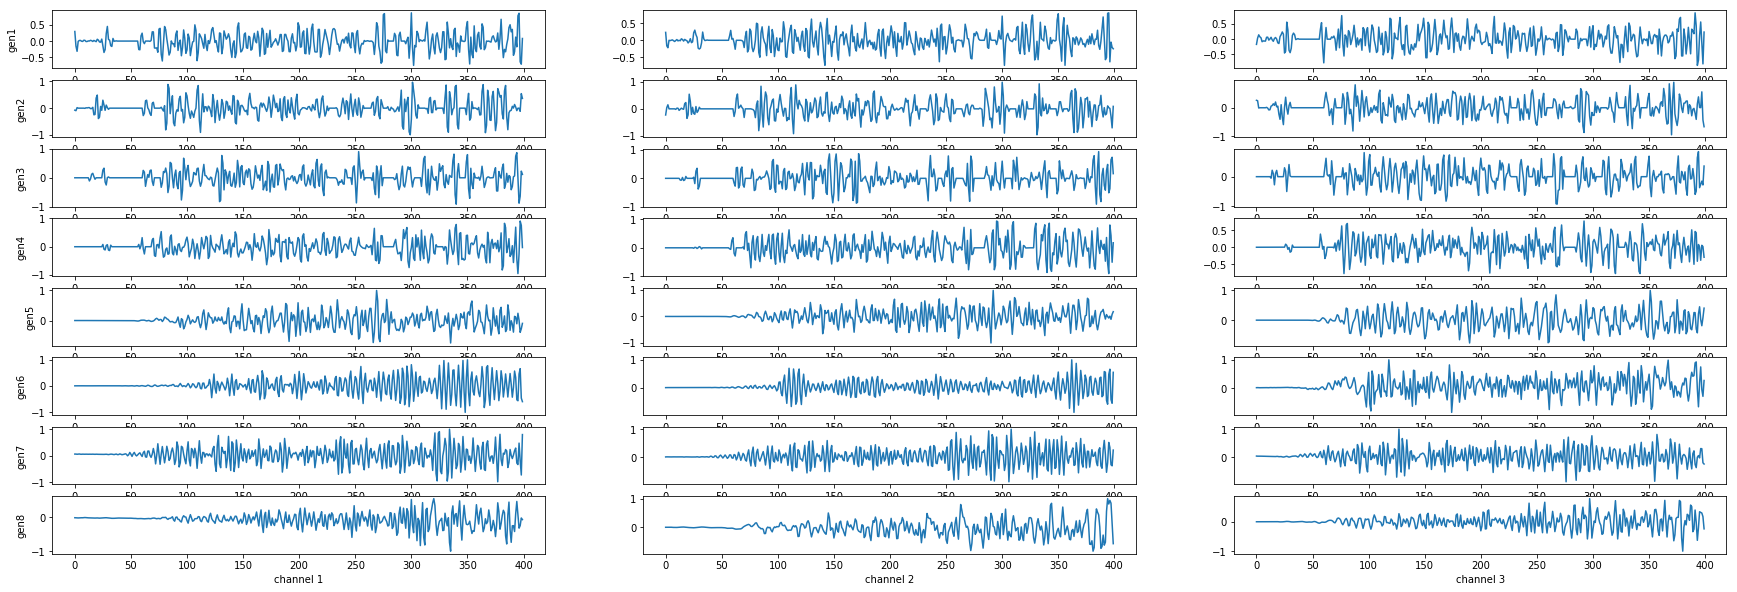

In [307]:
batch = gm.SG_train.random_batch()
x     = batch.x
v     = batch.metav # Defaults to None
# gm.plot_wforms(x, figsize = (30, 10));

N       = gm.batch_size
n       = 4 # Number of examples to show
predgen = gm.generator(gm.latent(n), conditional = v[0:n, ...])[:, :, 0, :]
fig     = gm.plot_wforms(np.vstack([predgen, x[0:n, ...]]), figsize = (30, 10), ylabels = ['gen' + str(i+1) for i in range(N)] + ['real' + str(i+1) for i in range(N)] )

global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, 'generated_wforms_at_step_{}_{}.png'.format(global_step, str(time.time()).split('.')[0])))

In [306]:
# show_graph(gm.graph.as_graph_def())